In [32]:
import tensorflow as tf
import time

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.33)

In [33]:
import tarfile
import re
import urllib.request
import os
import random

class ImdbMovieReviews:
    DEFAULT_URL = \
        'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
    TOKEN_REGEX = re.compile(r'[A-Za-z]+|[!?.:,()]')
    
    def __init__(self):
        self._cache_dir = './imdb'
        self._url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
        
        if not os.path.isfile(self._cache_dir):
            urllib.request.urlretrieve(self._url, self._cache_dir)
        self.filepath = self._cache_dir

    def __iter__(self):
        with tarfile.open(self.filepath) as archive:
            items = archive.getnames()
            for filename in archive.getnames():
                if filename.startswith('aclImdb/train/pos/'):
                    yield self._read(archive, filename), True
                elif filename.startswith('aclImdb/train/neg/'):
                    yield self._read(archive, filename), False
                    
    def _read(self, archive, filename):
        with archive.extractfile(filename) as file_:
            data = file_.read().decode('utf-8')
            data = type(self).TOKEN_REGEX.findall(data)
            data = [x.lower() for x in data]
            return data

In [34]:
import numpy as np
# Spacy is my favourite nlp framework, which havu builtin word embeddings trains on wikipesia
from spacy.en import English

class Embedding:
    
    def __init__(self):
#          spaCy makes using word vectors very easy. 
#             The Lexeme , Token , Span  and Doc  classes all have a .vector property,
#             which is a 1-dimensional numpy array of 32-bit floats:
        self.parser = English()
#         self._length = length
        self.dimensions = 300
        
    def __call__(self, sequence, length):
        # DO I really need them to be equal length?
        # Let's assume I'm not
        data = np.zeros((length, self.dimensions))
        # you can access known words from the parser's vocabulary
        embedded = [self.parser.vocab[w].vector for w in sequence]
        data[:len(sequence)] = embedded
        return data

In [35]:
import itertools

def preprocess_batched_split(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch = []
        labelss = []
        sentence_sizes_batch = []
        for index in range(batch_size):
            text, label = next(iterator)
            sents = [list(y) for x, y in itertools.groupby(text, lambda z: z == '.') if not x]
            sentence_sizes = [len(s) for s in sents]
            text_embed = [embedding(sent) for sent in sents]
            
            batch.append(text_embed)
            labelss.append(label)
            sentence_sizes_batch.append(sentence_sizes)
            
        labels_batch = np.array(labelss, dtype=np.int32)
        sent_per_doc = np.array([len(x) for x in sentence_sizes_batch])
        words_per_sent_per_doc = np.array(sentence_sizes_batch)
        yield np.array(batch), labels_batch, words_per_sent_per_doc, sent_per_doc

In [52]:
import itertools

def preprocess_batched_split2(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch, labels_b = zip(*itertools.islice(iterator, batch_size))
        
        sents_b = [[list(y) for x, y in itertools.groupby(doc, lambda z: z == '.') if not x] for doc in batch]

        sentence_sizes_b = [[len(sent) for sent in doc] for doc in sents_b]
        sentence_size = max(map(max, sentence_sizes_b))
        
        document_sizes = np.array([len(doc) for doc in sentence_sizes_b], dtype=np.int32)
        document_size = document_sizes.max()

        sentence_sizes_np = np.zeros(shape=[batch_size, document_size], dtype=np.int32)
        for bi, ds, ss in zip(range(sentence_sizes_np.shape[0]), document_sizes, sentence_sizes_b):
            sentence_sizes_np[bi][:ds] = ss
        
        text_embed_b = np.zeros((batch_size, document_size, sentence_size, 300))
        for i, ds, doc_sents in zip(range(text_embed_b.shape[0]), document_sizes, sents_b):
            doc_sents_embed = np.array([embedding(sent, sentence_size) for sent in doc_sents])
            text_embed_b[i][:ds] = doc_sents_embed
        
        yield text_embed_b, np.array(labels_b, dtype=np.int32), np.array(document_sizes), sentence_sizes_np, sents_b

In [37]:
reviews = list(ImdbMovieReviews())

In [38]:
random.shuffle(reviews)

In [39]:
#################################################

In [40]:
%load_ext autoreload
%autoreload 1
%aimport HanSequenceLabellingModel
%aimport model_components
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
HanSequenceLabellingModel HanSequenceLabellingModel, model_components model_components

Modules to skip:



In [53]:
batches_split = preprocess_batched_split2(reviews, Embedding(), batch_size=10)

In [54]:
from HanSequenceLabellingModel import HanSequenceLabellingModel

In [55]:
def HAN_model_1(session, restore_only=False, attention=True):
    """Hierarhical Attention Network"""
    import tensorflow as tf
    try:
        from tensorflow.contrib.rnn import GRUCell, MultiRNNCell, DropoutWrapper
    except ImportError:
        MultiRNNCell = tf.nn.rnn_cell.MultiRNNCell
        GRUCell = tf.nn.rnn_cell.GRUCell
    from bn_lstm import BNLSTMCell
    from HanSequenceLabellingModel import HanSequenceLabellingModel

    is_training = tf.placeholder(dtype=tf.bool, name='is_training')

    cell = BNLSTMCell(80, is_training) # h-h batchnorm LSTMCell
    cell = MultiRNNCell([cell]*5)

    model = HanSequenceLabellingModel(
            embedding_size=300,
            classes=2,
            word_cell=cell,
            sentence_cell=cell,
            word_output_size=300,
            sentence_output_size=300,
            learning_rate=0.001,
            max_grad_norm=5.0,
            dropout_keep_proba=0.5,
            is_training=is_training,
            attention=attention
    )

    saver = tf.train.Saver(tf.global_variables())
    checkpoint_dir = 'checkpoints'
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint:
        print("Reading model parameters from %s" % checkpoint.model_checkpoint_path)
        saver.restore(session, checkpoint.model_checkpoint_path)
    elif restore_only:
        raise FileNotFoundError("Cannot restore model")
    else:
        print("Created model with fresh parameters")
        session.run(tf.global_variables_initializer())
        
    return model, saver

In [44]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options)

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())

    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc,) in enumerate(batches_split):

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        t0 = time.clock()
        step, summaries, loss, accuracy, _ = s.run([
                model.global_step,
                model.summary,
                model.loss,
                model.accuracy,
                model.train_op,
        ], feed_dict=fd)
        td = time.clock() - t0

        summary_writer.add_summary(summaries, global_step=step)

        checkpoint_frequency = 100
        eval_frequency = 1
        
        if step % 1 == 0:
            print('step %s, loss=%s, accuracy=%s, t=%s, inputs=%s' % (step, loss, accuracy, round(td, 2), fd[model.inputs_embedded].shape))
        if step != 0 and step % checkpoint_frequency == 0:
            print('checkpoint & graph meta')
            checkpoint_path = 'checkpoints/checkpoint'
            saver.save(s, checkpoint_path, global_step=step)
            print('checkpoint done')

Reading model parameters from checkpoints/checkpoint-2500
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2500
step 2501, loss=0.37796, accuracy=0.8, t=12.27, inputs=(10, 23, 92, 300)
step 2502, loss=1.06319, accuracy=0.4, t=6.94, inputs=(10, 19, 63, 300)
step 2503, loss=0.813505, accuracy=0.8, t=15.69, inputs=(10, 27, 155, 300)
step 2504, loss=0.232972, accuracy=0.9, t=11.21, inputs=(10, 27, 103, 300)
step 2505, loss=0.0853661, accuracy=1.0, t=21.14, inputs=(10, 27, 218, 300)
step 2506, loss=0.155857, accuracy=1.0, t=10.71, inputs=(10, 43, 78, 300)
step 2507, loss=0.210453, accuracy=0.9, t=10.56, inputs=(10, 24, 98, 300)
step 2508, loss=0.411113, accuracy=0.7, t=8.84, inputs=(10, 28, 75, 300)
step 2509, loss=0.206383, accuracy=0.9, t=8.51, inputs=(10, 31, 70, 300)
step 2510, loss=0.605913, accuracy=0.7, t=12.01, inputs=(10, 30, 108, 300)
step 2511, loss=0.190947, accuracy=1.0, t=11.15, inputs=(10, 30, 104, 300)
step 2512, loss=0.497574, accuracy=0.7, t=21.07, inputs=(

KeyboardInterrupt: 

## Visualization

In [45]:
from colors import color

## Distribution

In [ ]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options)

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)

    data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_batch = next(batches_split)
    
    fd = \
    {
        model.is_training: True, 
        model.inputs_embedded: data, 
        model.word_lengths: words_per_sent_per_doc,
        model.sentence_lengths: sent_per_doc, 
        model.labels: labels_batch, 
        model.sample_weights: np.ones(shape=(10))
    }
    
    s_att, w_att = s.run([model.sentence_att, model.word_att], feed_dict=fd)
    
    review = sents_batch[0]
    review_att = np.squeeze(np.array(s_att[0]))
    word_review_att = np.squeeze(np.array(w_att))
    
    max_review_att = max(review_att)
    max_word_att = word_review_att.max()
    
    for i, sent in enumerate(review):
        col = int(255*review_att[i]/(1.5*max_review_att))
#         print(review_att[i], col, end='')
        print(color('   ', bg='#' + 'fd' + '%02x'%(255-col) + 'df'), end='')
        for j, word in enumerate(sent):
#            print(word_review_att[i][j], end='')
            col = int(255*word_review_att[i][j]/(1.5*max_word_att))
            print(color(word, bg='#' + 'ff' + '%02x'%(255-col) + 'ff'), end=' ')
        print()

In [85]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options)

good_neg = []
good_pos = []
bad_neg = []
bad_pos = []

iters = 100

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    
    fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }
    
    s_att, w_att = s.run([model.sentence_att, model.word_att], feed_dict=fd)
    
    for iter_, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, batch_reviews) in enumerate(batches_split):
        if iter_ == iters:
            break
        
        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        w_att = s.run([model.word_att], feed_dict=fd)
        word_review_att = np.squeeze(np.array(w_att))
        
        passed = 0
        for i, review in enumerate(batch_reviews):
            for j, sent in enumerate(review):
                for k, word in enumerate(sent):
                    att = word_review_att[passed + j][k]
                    if word == 'good':
                        if labels_batch[i] == 1:
                            good_pos.append(att)
                        else:
                            good_neg.append(att)
                    elif word == 'bad':
                        if labels_batch[i] == 1:
                            bad_pos.append(att)
                        else:
                            bad_neg.append(att)
            passed += len(review) + 1
        if iter_ % 10 == 0:
            print(iter_)

Reading model parameters from checkpoints/checkpoint-2500
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2500
0
10
20
30
40
50
60
70
80
90


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


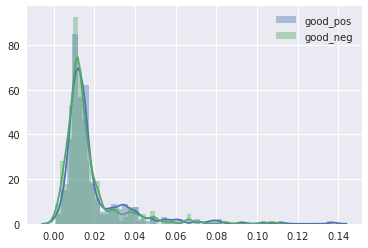

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.distplot(good_pos,  label='good_pos')
sns.distplot(good_neg,  label='good_neg')
plt.legend()

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


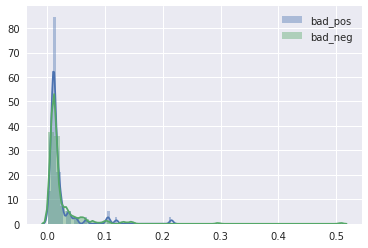

In [87]:
sns.distplot(bad_pos,  label='bad_pos')
sns.distplot(bad_neg,  label='bad_neg')
plt.legend()

## Compare accuracy

In [89]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options)

right = 0
count = 0

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s, True)

    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_b) in enumerate(batches_split):
        fd = {
            model.is_training: False,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.sample_weights: np.ones(shape=(10))
        }

        prediction = s.run(
            model.prediction
        , feed_dict=fd)

        for j in range(len(prediction)):
            count += 1
            if prediction[j] == labels_batch[j]:
                right += 1
        
        if i % 10 == 0:
            print(i, "accuracy=", right/count)

Reading model parameters from checkpoints/checkpoint-2500
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2500
0 accuracy= 0.9
10 accuracy= 0.8545454545454545
20 accuracy= 0.8571428571428571
30 accuracy= 0.8612903225806452
40 accuracy= 0.8707317073170732
50 accuracy= 0.8764705882352941
60 accuracy= 0.8737704918032787
70 accuracy= 0.8746478873239436
80 accuracy= 0.8728395061728395
90 accuracy= 0.8703296703296703
100 accuracy= 0.8683168316831683
110 accuracy= 0.8702702702702703
120 accuracy= 0.8652892561983471
130 accuracy= 0.867175572519084
140 accuracy= 0.8638297872340426
150 accuracy= 0.8629139072847682
160 accuracy= 0.8639751552795031
170 accuracy= 0.8631578947368421
180 accuracy= 0.8662983425414365
190 accuracy= 0.8649214659685864
200 accuracy= 0.8601990049751244
210 accuracy= 0.8625592417061612
220 accuracy= 0.8601809954751132
230 accuracy= 0.8601731601731601
240 accuracy= 0.8601659751037345
250 accuracy= 0.8577689243027888
260 accuracy= 0.8570881226053639
270 accu

KeyboardInterrupt: 